In [27]:
import torch
import umap
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.utils import audio_to_mel_spectrogram
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.mel_spectrogram_vae import MelSpectrogramVAE

In [28]:
sns.set()

In [29]:
# DAFX_TO_USE = [
#     'mda RingMod',
#     'mda Combo',
# ]

In [4]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Delay"
DAFX_FORMATTED_NAME = DAFX_NAME.split()[-1]
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_melspec_vae/eu2tcrkn/checkpoints/epoch=237-step=74494.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FIG_SAVE_PREFIX = f"./figures/domain_colouring/{CHECKPOINT_ID}_{DAFX_FORMATTED_NAME}"

In [5]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [6]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=130_560,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [7]:
def get_colour(x, y):
    assert(0 <= x <= 1)
    assert(0 <= y <= 1)

    # calculate the red, green, and blue values based on x and y coordinates
    red = int(x * 255)
    green = int(y * 255)
    blue = int(0.5 * 255)

    def clamp(color):
      return max(0, min(color, 255))

    hex = "#{0:02x}{1:02x}{2:02x}".format(clamp(red), clamp(green), clamp(blue))

    # return the RGBA value as hex
    return hex


In [8]:
dafx = dafx_from_name(DAFX_NAME)

In [9]:
dafx.param_names

['l_delay_ms', 'r_delay', 'feedback', 'fb_tone_lo_hi', 'fb_mix']

In [10]:
model = MelSpectrogramVAE.load_from_checkpoint(CHECKPOINT)
model.eval()
model = model.to(DEVICE)

In [11]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 42144.18it/s]


Loaded 88 files for train = 66.89 hours.


In [12]:
latent_embeddings = []
param_settings = []

for batch in tqdm(dataset):
    y = batch

    setting = torch.rand(dafx.get_num_params()).to(DEVICE)

    # Apply setting to audio
    y = dafx.apply(y, setting)
    y = y.unsqueeze(0).unsqueeze(0)

    X = audio_to_mel_spectrogram(signal=y,
                                 sample_rate=model.hparams.sample_rate,
                                 n_mels=model.hparams.n_mels,
                                 n_fft=model.hparams.n_fft,
                                 win_length=model.hparams.win_length,
                                 f_max=model.hparams.f_max,
                                 f_min=model.hparams.f_min).to(DEVICE)

    _, _, _, z = model(X)

    latent_embeddings.append(z.cpu().detach().numpy())
    param_settings.append(setting.cpu().detach().numpy())

100%|██████████| 10000/10000 [01:36<00:00, 103.95it/s]


In [13]:
data = np.array(latent_embeddings).squeeze()

In [14]:
raw_embeddings = umap.UMAP().fit_transform(data)

In [15]:
## Perform min/max normalisation across dimensions
emb = (raw_embeddings - raw_embeddings.min(0)) / raw_embeddings.ptp(0)

In [16]:
params = np.array(param_settings)

In [17]:
colours = [get_colour(e[0], e[1]) for e in emb]

In [18]:
df_data = {dafx.idx_to_param_map[i]: params[:,i] for i in range(dafx.get_num_params())}

df_data['x_embed'] = emb[:,0]
df_data['y_embed'] = emb[:,1]
df_data['colour'] = colours

In [19]:
df = pd.DataFrame(df_data)

In [20]:
df.head()

,l_delay_ms,r_delay,feedback,fb_tone_lo_hi,fb_mix,x_embed,y_embed,colour
0,0.061898,0.638173,0.736986,0.614699,0.346808,0.642223,0.664106,#a3a97f
1,0.870044,0.864161,0.693882,0.755710,0.969700,0.788777,0.394956,#c9647f
2,0.511048,0.461333,0.398301,0.081372,0.782851,0.221260,0.278113,#38467f
3,0.020203,0.653218,0.074923,0.174803,0.680662,0.048814,0.593479,#0c977f
4,0.206945,0.121650,0.364414,0.338500,0.528322,0.731206,0.788051,#bac87f


In [21]:
# # create pairplot with hex color values
# sns.pairplot(df.drop(['x_embed', 'y_embed'], axis=1), hue='colour', palette=sns.color_palette(df['colour'].unique()))
#
# plt.show()

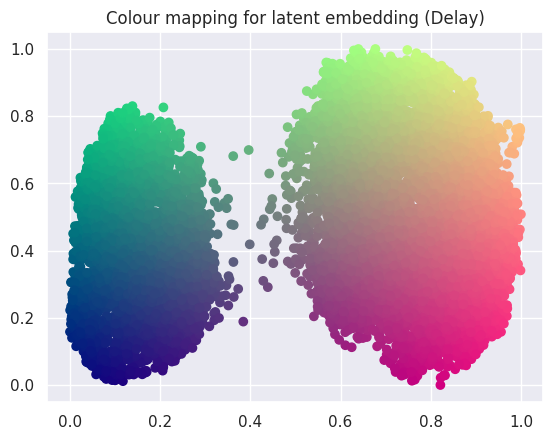

In [22]:
plt.scatter(df['x_embed'], df['y_embed'], c=df['colour'])
plt.title(f"Colour mapping for latent embedding ({DAFX_FORMATTED_NAME})")
plt.savefig(f"{FIG_SAVE_PREFIX}_cmapping.png")

In [23]:
def get_subplot_dimensions(N, max_columns=None):
    if max_columns is None or N <= max_columns:
        # If max_columns is not specified or N is less than or equal to max_columns,
        # then the number of columns required is equal to N.
        # In this case, the number of rows required is 1.
        return 1, N

    # If N is greater than max_columns, we need to calculate the number of rows required.
    rows = math.ceil(N / max_columns)
    cols = max_columns

    return rows, cols

In [24]:
def calculate_upper_triangular_entries(n):
    return int((n*(n-1)) / 2)

In [25]:
n_plots = calculate_upper_triangular_entries(5)
print(f"{n_plots} plots")

n_rows, n_columns = get_subplot_dimensions(n_plots, max_columns=3)
print(f"n_rows = {n_rows}, n_columns = {n_columns}")

10 plots
n_rows = 4, n_columns = 3


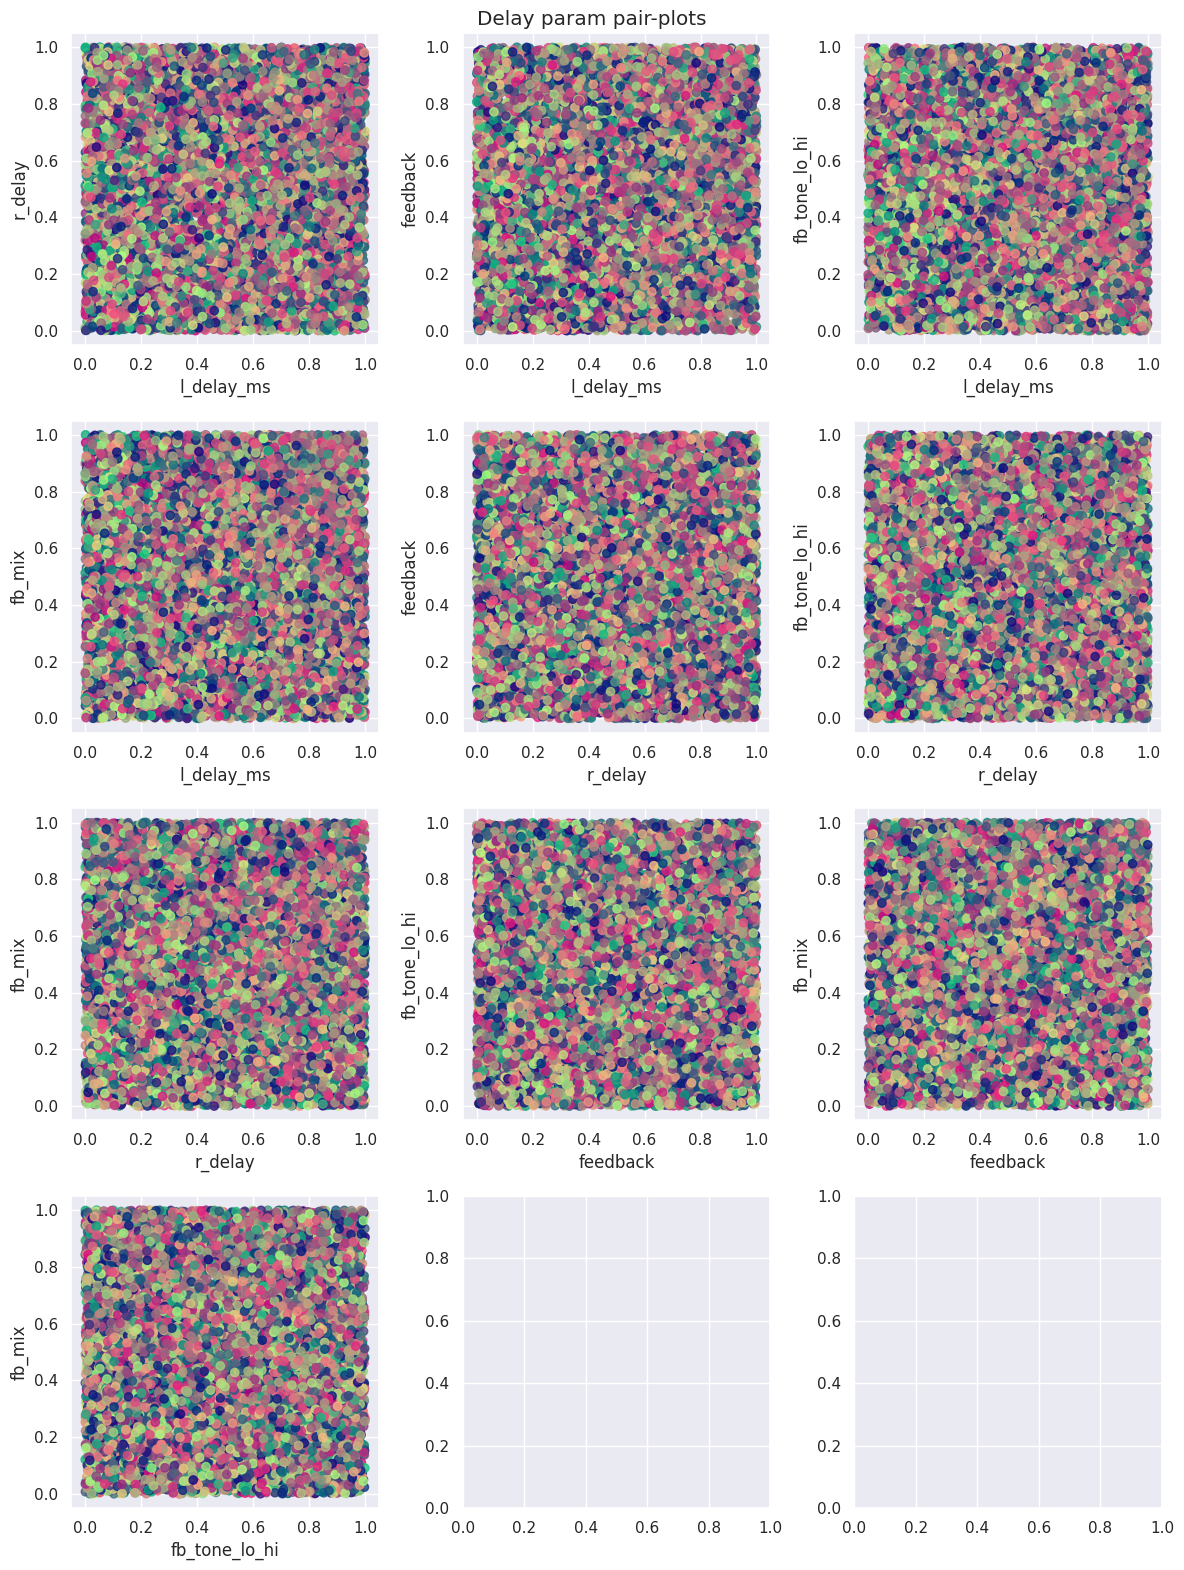

In [26]:
# Define the size of the matrix
n = dafx.get_num_params()

# Calculate the number of rows and columns required for the subplots
max_columns = 3  # set a maximum number of columns
num_axes = math.ceil((n**2 - n) / 2)  # calculate the number of upper triangular elements
num_rows, num_cols = get_subplot_dimensions(num_axes, max_columns=max_columns)

# Create the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows, ))

# Loop over the upper triangular elements
count = 0
for i in range(n):
    for j in range(i + 1, n):
        # Plot the i and j indices on the current subplot
        row_idx, col_idx = divmod(count, num_cols)

        if num_rows == 1:
            current_ax = axs[col_idx]
        elif num_cols == 1:
            current_ax = axs[row_idx]
        else:
            current_ax = axs[row_idx, col_idx]

        current_ax.scatter(df.iloc[:,i], df.iloc[:,j], c=df['colour'], alpha=0.8)

        i_label = dafx.idx_to_param_map[i]
        j_label = dafx.idx_to_param_map[j]

        current_ax.set_xlabel(i_label)
        current_ax.set_ylabel(j_label)

        # current_ax.set_title(f"({i}, {j})")

        count += 1

        # If we have processed all the subplots, break out of the loop
        if count == num_axes:
            break

# If we have fewer subplots than required, remove the remaining subplots
while count < num_axes:
    row_idx, col_idx = divmod(count, num_cols)
    fig.delaxes(axs[row_idx, col_idx])
    count += 1

fig.suptitle(f"{DAFX_FORMATTED_NAME} param pair-plots")

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.savefig(f"{FIG_SAVE_PREFIX}_pairplots.png")